In [13]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve


# Математическая справка

## 1. Начальное уравнение

В задаче требуется решить уравнение Пуассона:

$$
u_{xx} + u_{yy} = f(x,y),
$$

в прямоугольной области по x и y.

---

## 2. Граничные условия в новой работе

По оси **x** — периодические условия:

$$
u(0,y) = u(L_x, y), \qquad
u_x(0,y) = u_x(L_x,y).
$$

То есть левая и правая границы “склеены”.

По оси **y** — условия Дирихле:

$$
u(x, y_{\min}) = u_-(x), \qquad
u(x, y_{\max}) = u_+(x).
$$

Температура на верхней и нижней границах известна.

---

## 3. Переход к сетке

Разбиваем область на прямоугольную сетку:

$$
x_i = x_0 + i h_x,\qquad i=0,\dots,N_x-1,
$$

$$
y_j = y_0 + j h_y,\qquad j=0,\dots,N_y+1.
$$

Во внутренних узлах:

$$
u_{i,j} \approx u(x_i, y_j).
$$

Граничные узлы по y нам известны (Дирихле) и в систему не входят.

---

## 4. Разностная аппроксимация производных

### Вторая производная по x (с учётом периодичности):

$$
u_{xx}(x_i,y_j) \approx
\frac{
u_{i+1,j} - 2u_{i,j} + u_{i-1,j}
}{h_x^2},
$$

где индексы берутся по модулю:

$$
u_{-1,j} = u_{N_x-1,j}, \qquad
u_{N_x,j} = u_{0,j}.
$$

### Вторая производная по y:

$$
u_{yy}(x_i,y_j) \approx
\frac{
u_{i,j+1} - 2u_{i,j} + u_{i,j-1}
}{h_y^2}.
$$

Если сосед сверху/снизу — граничный узел, его значение берётся из условия Дирихле.

---

## 5. Сборка дискретного уравнения

Подставляем обе аппроксимации в уравнение Пуассона:

$$
\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h_x^2}
+
\frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h_y^2}
=
f_{i,j}.
$$

Это уравнение записывается для каждого внутреннего узла по y и всех узлов по x.

---

## 6. Переход к матричному виду (Au = b)

Собираем все неизвестные в один вектор **u**.  
Тогда вся система принимает вид:

$$
A u = b,
$$

где:

- **A** — разреженная матрица Лапласа с учётом периодичности по x  
  (в каждой строке не более 5 ненулевых элементов),
- **b** — правая часть, включающая \(f_{i,j}\) и вклад граничных значений по y.

В этой лабораторной работе система решается встроенным решателем:

```
from scipy.sparse.linalg import spsolve
u = spsolve(A, b)
```

---

## 7. Порядок точности

Используемая центрально-разностная схема второго порядка даёт:

$$
\|u_{\text{числ}} - u_{\text{точ}}\| \sim O(h^2).
$$

Это подтверждается графиком сходимости.


In [14]:
def create_grid_x_y(Nx, Ny, Lx, y_min, y_max):

    hx = Lx / Nx
    x = np.linspace(0, Lx - hx, Nx)  # 0 .. Lx-hx

    hy = (y_max - y_min) / (Ny + 1)
    y_full = np.linspace(y_min, y_max, Ny + 2)
    y = y_full[1:-1]  # только внутренние узлы
    return x, y, hx, hy, y_full


def idx(i, j, Nx, Ny):
    """
    Преобразование пары индексов (i,j) в один индекс k.
    i = 0..Nx-1
    j = 0..Ny-1   (j соответствует внутренним узлам по y)
    Нумерация: сначала x, потом y.
    """
    return j * Nx + i


In [15]:
def assemble_system(Nx, Ny, Lx, y_min, y_max,
                    f_func,  # f(x,y)
                    bottom_bc,  # u(x, y_min)
                    top_bc):    # u(x, y_max)
    """
    Формирует матрицу A (CSR) и вектор b для задачи Пуассона.

    f_func(x, y)     - правая часть
    bottom_bc(x)     - граничное условие при y = y_min
    top_bc(x)        - граничное условие при y = y_max
    """
    x, y, hx, hy, y_full = create_grid_x_y(Nx, Ny, Lx, y_min, y_max)
    hx2 = hx * hx
    hy2 = hy * hy

    A = lil_matrix((Nx * Ny, Nx * Ny))
    b = np.zeros(Nx * Ny)

    # значения граничных условий по y
    x_bc = x  # те же x
    u_bottom = bottom_bc(x_bc)
    u_top = top_bc(x_bc)

    for j in range(Ny):
        for i in range(Nx):
            k = idx(i, j, Nx, Ny)

            # координаты текущего узла
            xi = x[i]
            yj = y[j]

            # коэффициенты схемы
            ax = 1.0 / hx2
            ay = 1.0 / hy2
            a0 = -2.0 * (ax + ay)

            A[k, k] = a0

            # соседи по x (с учётом периодичности)
            ip = (i + 1) % Nx  # i+1
            im = (i - 1) % Nx  # i-1

            kp = idx(ip, j, Nx, Ny)
            km = idx(im, j, Nx, Ny)

            A[k, kp] = ax
            A[k, km] = ax

            # соседи по y
            # верхний и нижний могут быть как внутренними, так и граничными
            # j+1
            if j + 1 < Ny:
                kjp = idx(i, j + 1, Nx, Ny)
                A[k, kjp] = ay
            else:
                # сосед сверху - граничный слой y = y_max
                b[k] -= ay * u_top[i]

            # j-1
            if j - 1 >= 0:
                kjm = idx(i, j - 1, Nx, Ny)
                A[k, kjm] = ay
            else:
                # сосед снизу - граничный слой y = y_min
                b[k] -= ay * u_bottom[i]

            # правая часть
            b[k] += f_func(xi, yj)

    return csr_matrix(A), b, x, y


In [16]:
def solve_poisson(Nx, Ny, Lx, y_min, y_max,
                  f_func, bottom_bc, top_bc):
    """
    Решает уравнение Пуассона с заданными функциями
    и возвращает сетки x, y и двумерный массив u[j, i]
    (j — индекс по y, i — по x).
    """
    A, b, x, y = assemble_system(Nx, Ny, Lx, y_min, y_max,
                                 f_func, bottom_bc, top_bc)
    u_vec = spsolve(A, b)
    u = u_vec.reshape((Ny, Nx))  # j, i
    return x, y, u


In [17]:
def solve_poisson(Nx, Ny, Lx, y_min, y_max,
                  f_func, bottom_bc, top_bc):
    """
    Решает уравнение Пуассона с заданными функциями
    и возвращает сетки x, y и двумерный массив u[j, i]
    (j — индекс по y, i — по x).
    """
    A, b, x, y = assemble_system(Nx, Ny, Lx, y_min, y_max,
                                 f_func, bottom_bc, top_bc)
    u_vec = spsolve(A, b)
    u = u_vec.reshape((Ny, Nx))  # j, i
    return x, y, u


In [18]:
# Параметры сетки
Nx = 80
Ny = 80
Lx = np.pi
y_min = -1.0
y_max = 1.0

# Правая часть и граничные условия
def f_a(x, y):
    return 4.0 - 29.0 * np.sin(2.0 * x + 5.0 * y)

def bottom_bc_a(x):
    return 2.0 + np.sin(2.0 * x - 5.0)

def top_bc_a(x):
    return 2.0 + np.sin(2.0 * x + 5.0)

def u_exact_a(x, y):
    return np.sin(2.0 * x + 5.0 * y) + 2.0 * y**2

# Решаем
x_a, y_a, u_num_a = solve_poisson(Nx, Ny, Lx, y_min, y_max,
                                  f_a, bottom_bc_a, top_bc_a)

# Вычисляем точное решение в узлах
X_a, Y_a = np.meshgrid(x_a, y_a)
u_ex_a = u_exact_a(X_a, Y_a)

error_a = u_num_a - u_ex_a
max_error = np.max(np.abs(error_a))
l2_error = np.sqrt(np.mean(error_a**2))

print(f"Пункт (a): Nx={Nx}, Ny={Ny}")
print(f"Максимальная погрешность  ||e||_inf = {max_error:.3e}")
print(f"Среднеквадратичная       ||e||_2   = {l2_error:.3e}")


Пункт (a): Nx=80, Ny=80
Максимальная погрешность  ||e||_inf = 1.506e-03
Среднеквадратичная       ||e||_2   = 8.641e-04


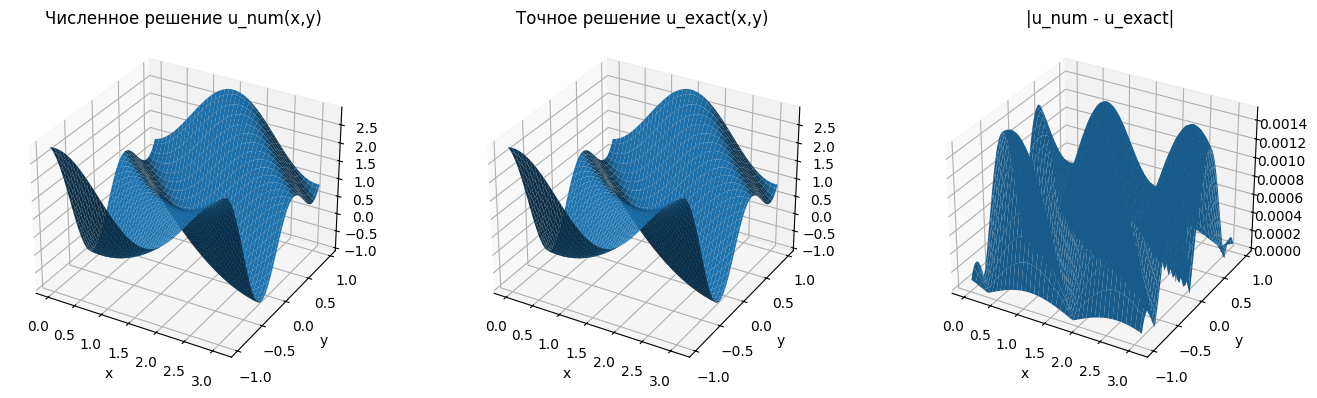

In [19]:
fig = plt.figure(figsize=(14, 4))

# Численное решение
ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.plot_surface(X_a, Y_a, u_num_a, linewidth=0, antialiased=True)
ax1.set_title("Численное решение u_num(x,y)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

# Точное решение
ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.plot_surface(X_a, Y_a, u_ex_a, linewidth=0, antialiased=True)
ax2.set_title("Точное решение u_exact(x,y)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

# Ошибка
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.plot_surface(X_a, Y_a, np.abs(error_a), linewidth=0, antialiased=True)
ax3.set_title("|u_num - u_exact|")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

plt.tight_layout()
plt.show()


In [20]:
def compute_error_for_grid(Nx, Ny):
    x, y, u_num = solve_poisson(Nx, Ny, np.pi, -1.0, 1.0,
                                f_a, bottom_bc_a, top_bc_a)
    X, Y = np.meshgrid(x, y)
    u_ex = u_exact_a(X, Y)
    error = u_num - u_ex
    return np.max(np.abs(error)), np.sqrt(np.mean(error**2)), x[1] - x[0], y[1] - y[0]

grid_sizes = [20, 40, 80, 160]
errors_inf = []
hx_list = []

print("Nx = Ny|  h_x     |  ||e||_inf")
print("-----------------------------------")
for N in grid_sizes:
    e_inf, e_l2, hx, hy = compute_error_for_grid(N, N)
    errors_inf.append(e_inf)
    hx_list.append(hx)
    print(f"{N:6d} | {hx:8.4f} | {e_inf:10.3e}")


Nx = Ny|  h_x     |  ||e||_inf
-----------------------------------
    20 |   0.1571 |  2.267e-02
    40 |   0.0785 |  5.895e-03
    80 |   0.0393 |  1.506e-03
   160 |   0.0196 |  3.809e-04


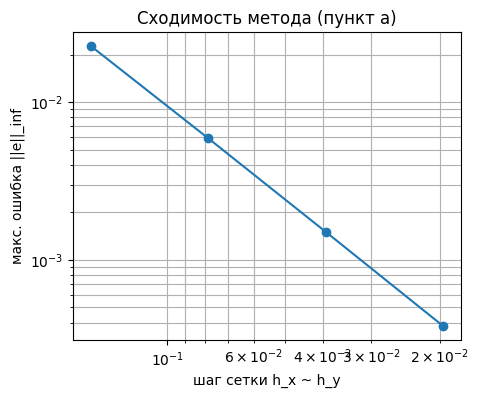

In [21]:
plt.figure(figsize=(5,4))
plt.loglog(hx_list, errors_inf, marker="o")
plt.gca().invert_xaxis()
plt.xlabel("шаг сетки h_x ~ h_y")
plt.ylabel("макс. ошибка ||e||_inf")
plt.title("Сходимость метода (пункт a)")
plt.grid(True, which="both")
plt.show()


In [ ]:
# Параметры области для пункта (b)
Nx_b = 100
Ny_b = 80
Lx_b = np.pi
y_min_b = 0.0
y_max_b = 1.0

# Параметры "точечных" источников (гауссианы)
sigma = 0.1
sources = [
    (3, 0.3, 5.0),
    (1.8, 0.7, 8.0),
    (2.5, 0.4, 6.0),
    (2.9, 0.9, 4.0),
]

def f_b(x, y):
    val = 0.0
    for (xc, yc, Q) in sources:
        val += Q * np.exp(-((x - xc)**2 + (y - yc)**2) / sigma**2)
    return val

def bottom_bc_b(x):
    # T0 = 0
    return np.zeros_like(x)

def top_bc_b(x):
    # T0 = 0
    return np.zeros_like(x)

# Решение
x_b, y_b, u_b = solve_poisson(Nx_b, Ny_b, Lx_b, y_min_b, y_max_b,
                              f_b, bottom_bc_b, top_bc_b)

X_b, Y_b = np.meshgrid(x_b, y_b)


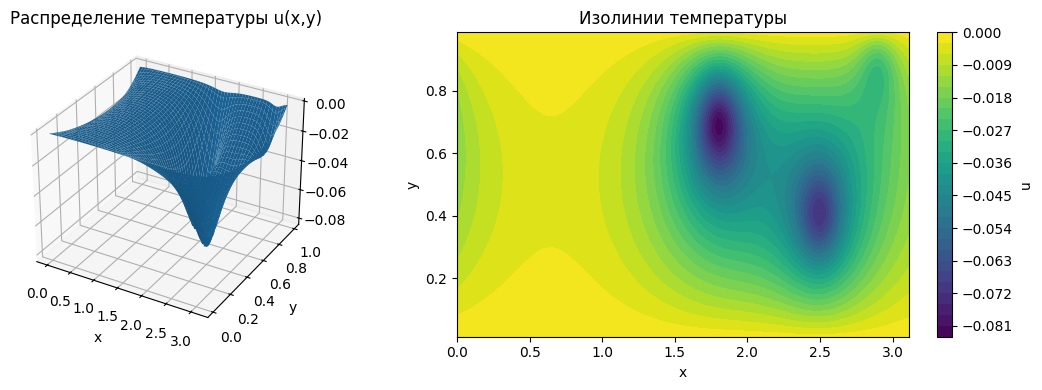

In [30]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_surface(X_b, Y_b, u_b, linewidth=0, antialiased=True)
ax1.set_title("Распределение температуры u(x,y)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2 = fig.add_subplot(1, 2, 2)
cont = ax2.contourf(X_b, Y_b, u_b, levels=30)
ax2.set_title("Изолинии температуры")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cont, ax=ax2, label="u")

plt.tight_layout()
plt.show()
